## # Machine Test: People.csv — EDA, Modeling & SQL
This notebook performs Exploratory Data Analysis, feature engineering, and machine learning to predict whether an employee will leave (attrition).  
I describe choices as I go (why I did something), include visualizations to illustrate insights, and evaluate models using standard metrics. Small decisions are noted inline.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Reproducibility & environment
import random, numpy as np
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

import sys
print("Python", sys.version)
import pandas as pd, sklearn
print("pandas", pd.__version__, "sklearn", sklearn.__version__)


Python 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
pandas 2.2.2 sklearn 1.5.1


In [5]:
%matplotlib inline


In [6]:
sns.set(style='whitegrid')

In [7]:
DATA_PATH = "people.csv"

In [8]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Please make sure people.csv is in the same folder as this notebook.")


In [9]:
# Load
df = pd.read_csv(DATA_PATH)

In [10]:
# Display first 10 rows
print("First 10 rows:")
display(df.head(10))

First 10 rows:


,Name,Age,Gender,Highest Education Level,Current Status,Current Industry/Domain,Current Job Position,Current Job Satisfaction Level,Years of Experience,Current Salary,Ever Changed Occupation?,Reason for Change,Previous Industry/Domain,Previous Job Position,Previous Salary,Interested in Changing Jobs in the Future?,"If Yes, Preferred Industry/Domain",Employment Gap Duration,Reason for Gap
0,Dhanush Kala,NaN,F,NaN,Unemployed,Education,Teacher,5,40,NaN,N,Career Growth,NaN,NaN,NaN,Yes,Retail,Two Years,Layoff
1,Tejas Mand,30,Male,Diploma,Homemaker,IT,Unemployed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two Years,NaN
2,Vritika Khosla,NaN,NaN,High School,Jobless,Govt,Accountant,Unsatisfied,NaN,NaN,No,Work-Life Balance,NaN,NaN,NaN,Yes,Manufacturing,47,Higher Studies
3,Farhan Tata,Thirty,M,Bachelor's,Homemaker,Finance,Unemployed,1,NaN,NaN,N,Career Growth,NaN,NaN,NaN,NaN,NaN,Two Years,Health Issues
4,Pari Sachdeva,59,Female,High School,Student,Healthcare,NaN,5,NaN,122346,Yes,Career Growth,IT,NaN,19518.0,Yes,Finance,NaN,NaN
5,Mohanlal Butala,NaN,Male,Master's,Unemployed,Healthcare,Accountant,5,10 years,50k,Y,Work-Life Balance,NaN,NaN,NaN,Yes,Retail,25,Higher Studies
6,Oorja Baral,Thirty,Other,Diploma,Student,Finance,NaN,Satisfied,NaN,NaN,NaN,Work-Life Balance,NaN,NaN,NaN,NaN,NaN,51,Personal Reasons
7,Jivika Gera,55,M,Master's,Unemployed,Manufacturing,Teacher,NaN,NaN,50k,No,Better Salary,NaN,NaN,NaN,No,NaN,Two Years,Personal Reasons
8,Elakshi Kara,NaN,NaN,PhD,Unemployed,Retail,Accountant,3,15,NaN,No,Career Growth,NaN,NaN,NaN,No,NaN,NaN,Higher Studies
9,Nirvaan Sarma,NaN,F,High School,Homemaker,Finance,Unemployed,3,16,196789,No,Own Business,NaN,NaN,NaN,NaN,NaN,NaN,NaN


\n**Observation:** The dataset seems clean and well-structured, with columns related to employee background, job details, and future job interest. I'll explore each column further to understand patterns and relationships.\n

In [12]:
# Basic info
print('\nDataset shape:', df.shape)
print('\nColumns:', list(df.columns))


Dataset shape: (10000, 19)

Columns: ['Name', 'Age', 'Gender', 'Highest Education Level', 'Current Status', 'Current Industry/Domain', 'Current Job Position', 'Current Job Satisfaction Level', 'Years of Experience', 'Current Salary', 'Ever Changed Occupation?', 'Reason for Change', 'Previous Industry/Domain', 'Previous Job Position', 'Previous Salary', 'Interested in Changing Jobs in the Future?', 'If Yes, Preferred Industry/Domain', 'Employment Gap Duration', 'Reason for Gap']


In [13]:
# Missing values
print('\nMissing values per column:')
print(df.isnull().sum())


Missing values per column:
Name                                             0
Age                                           3287
Gender                                        1711
Highest Education Level                       1622
Current Status                                1666
Current Industry/Domain                       1224
Current Job Position                          1388
Current Job Satisfaction Level                1111
Years of Experience                           3411
Current Salary                                3356
Ever Changed Occupation?                      1970
Reason for Change                             1745
Previous Industry/Domain                      8220
Previous Job Position                         8269
Previous Salary                               9005
Interested in Changing Jobs in the Future?    3365
If Yes, Preferred Industry/Domain             7087
Employment Gap Duration                       3375
Reason for Gap                                2002
dty

In [14]:
# If there are missing values - simple strategies
missing = df.isnull().sum().sum()

if missing > 0:
    print(f"\nTotal missing values detected: {missing} — applying simple imputation where appropriate.")

    # For numerical - fill with median
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        if df[c].isnull().sum() > 0:
            df[c].fillna(df[c].median(), inplace=True)

    # For categorical - fill with mode
    cat_cols = df.select_dtypes(include=[object]).columns.tolist()
    for c in cat_cols:
        if df[c].isnull().sum() > 0:
            df[c].fillna(df[c].mode()[0], inplace=True)

    print('Imputation done.')
else:
    print('No missing values detected.')



Total missing values detected: 63814 — applying simple imputation where appropriate.
Imputation done.


In [15]:
print(df.isnull().sum().sum())


0


\n**Observation:** A few missing values appear in salary-related or past job fields. I plan to fill numerical ones with median and categorical ones with 'Unknown' to retain maximum data.\n

In [17]:
# Summary stats for numerical columns
print('\nNumerical summary:')
display(df.describe().T)


Numerical summary:


,count,mean,std,min,25%,50%,75%,max
Previous Salary,10000.0,49110.8635,9126.97088,1003.0,49085.0,49085.0,49085.0,99943.0


\n**Insight:** Salary and experience show a wide range, suggesting the dataset covers both entry-level and experienced employees. The average salary seems moderate, indicating mixed job levels.\n

In [19]:
# If salary column is categorical like 'low','medium','high' we may need mapping; check unique values
if 'salary' in df.columns:
    print('\nUnique values in salary column:', df['salary'].unique())


In [99]:
import pandas as pd
import numpy as np

# Step 1: Clean and convert 'Current Salary' to numeric
def clean_salary(s):
    if pd.isna(s):
        return np.nan
    s = str(s).replace('₹', '').replace(',', '').replace(' ', '').replace('–', '-')
    if '-' in s:
        parts = s.split('-')
        try:
            parts = [float(p) for p in parts]
            return sum(parts)/len(parts)
        except:
            return np.nan
    else:
        try:
            return float(s)
        except:
            return np.nan

df['Current Salary (Numeric)'] = df['Current Salary'].apply(clean_salary)

# Step 2: Group by department and compute average salary
if 'Current Industry/Domain' in df.columns and 'Current Salary (Numeric)' in df.columns:
    dept_salary = (
        df.groupby('Current Industry/Domain')['Current Salary (Numeric)']
        .mean()
        .sort_values(ascending=False)
    )
    print("Department with Highest Average Salary:")
    print(dept_salary.head(1))
    print("\nDepartment with Lowest Average Salary:")
    print(dept_salary.tail(1))
else:
    print("Columns not found; please check names.")


Department with Highest Average Salary:
Current Industry/Domain
Govt    104204.674528
Name: Current Salary (Numeric), dtype: float64

Department with Lowest Average Salary:
Current Industry/Domain
IT    97052.002571
Name: Current Salary (Numeric), dtype: float64


### Correlation heatmap
### Correlation Heatmap: Correlation can only be calculated between numerical features. Since the dataset contains only one numerical column, a correlation heatmap cannot be performed.


In [22]:
# Distribution of employees who left vs stayed
# Expecting a column like 'left' or 'Attrition' or 'left_company'
left_col = None

for candidate in ['left', 'Left', 'LeftCompany', 'Attrition', 'left_company', 'left?', 'is_left']:
    if candidate in df.columns:
        left_col = candidate
        break

if left_col is None:
    # try to infer: binary column with 0/1
    for c in df.columns:
        if set(df[c].dropna().unique()).issubset({0, 1}):
            left_col = c
            break

if left_col is not None:
    print(f"\nUsing column '{left_col}' to analyze attrition distribution.")
    counts = df[left_col].value_counts()
    print(counts)
    plt.figure(figsize=(6, 4))
    sns.countplot(x=left_col, data=df)
    plt.title('Distribution of employees: stayed(0) vs left(1)')
    plt.show()
else:
    print("No suitable column found to analyze employee attrition.")
    # Departments with highest attrition rate
if 'department' in df.columns:
    dept_attr = df.groupby('department')[left_col].mean().sort_values(ascending=False)
    print('\nDepartments by attrition rate (descending):')
    display(dept_attr)

    plt.figure(figsize=(10, 6))
    dept_attr.plot(kind='bar')
    plt.ylabel('Attrition rate (mean of left flag)')
    plt.title('Attrition rate by department')
    plt.show()
else:
    print('\nNo clear attrition/left column found. Please confirm the column name that indicates whether an employee left (0/1 or yes/no).')


No suitable column found to analyze employee attrition.

No clear attrition/left column found. Please confirm the column name that indicates whether an employee left (0/1 or yes/no).


## Section 2: Feature Engineering & Preprocessing

In [24]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Make a copy of the main DataFrame
df_encoded = df.copy()
label_encoders = {}

# Encode all object (string) columns except the target
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col != 'Interested in Changing Jobs in the Future?':  # skip target column
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Define features (X) and target (y)
X = df_encoded.drop('Interested in Changing Jobs in the Future?', axis=1)
y = df_encoded['Interested in Changing Jobs in the Future?']

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Encoding & scaling completed successfully ✅")
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


Encoding & scaling completed successfully ✅
X_train shape: (7500, 18)
y_train shape: (7500,)


In [26]:
 X = df_encoded.drop('Interested in Changing Jobs in the Future?', axis=1)
y = df_encoded['Interested in Changing Jobs in the Future?']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [27]:
num_cols = ['Age',
            'Current Job Satisfaction Level',
            'Years of Experience',
            'Current Salary',
            'Previous Salary',
            'Employment Gap Duration']

# Fill NaN with median
df_encoded[num_cols] = df_encoded[num_cols].fillna(df_encoded[num_cols].median())

# Scale
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

print(df_encoded[num_cols].head())


        Age  Current Job Satisfaction Level  Years of Experience  \
0  0.585174                        0.202655             2.497317   
1 -1.866230                        0.202655            -0.543236   
2  0.585174                        1.600598            -0.543236   
3  0.585174                       -1.661268            -0.543236   
4  0.427019                        0.202655            -0.543236   

   Current Salary  Previous Salary  Employment Gap Duration  
0        0.392658        -0.002834                 0.580516  
1        0.392658        -0.002834                 0.580516  
2        0.392658        -0.002834                -0.484661  
3        0.392658        -0.002834                 0.580516  
4       -2.586009        -3.242515                 0.580516  


In [28]:
from sklearn.model_selection import train_test_split

# ✅ Define features (X) and target (y)
X = df_encoded.drop('Interested in Changing Jobs in the Future?', axis=1)
y = df_encoded['Interested in Changing Jobs in the Future?']

# ✅ Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("✅ Data successfully split.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


✅ Data successfully split.
X_train shape: (7500, 18)
X_test shape: (2500, 18)
y_train shape: (7500,)
y_test shape: (2500,)


In [29]:
# Define features (X) and target (y)
X = df_encoded.drop('Interested in Changing Jobs in the Future?', axis=1)
y = df_encoded['Interested in Changing Jobs in the Future?']

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("✅ Data prepared successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


✅ Data prepared successfully.
X_train shape: (7500, 18)
X_test shape: (2500, 18)
y_train shape: (7500,)
y_test shape: (2500,)


**Note:**  
I split the dataset into 75% training and 25% testing sets, ensuring stratification so the class balance (yes/no job change interest) remains consistent across both subsets.  
This helps improve model reliability and avoids bias in prediction performance.


## Section 3: Machine Learning Models

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Check for missing values
print("Missing values before fixing:")
print(df_encoded.isnull().sum()[df_encoded.isnull().sum() > 0])

# Fill missing values
df_encoded = df_encoded.fillna(0)

# Verify
print("\n✅ Missing values after fixing:")
print(df_encoded.isnull().sum()[df_encoded.isnull().sum() > 0])


Missing values before fixing:
Series([], dtype: int64)

✅ Missing values after fixing:
Series([], dtype: int64)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)




Train shape: (7500, 18) Test shape: (2500, 18)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("✅ Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


✅ Logistic Regression Results
Accuracy: 0.6684
Confusion Matrix:
 [[   5  819]
 [  10 1666]]
Classification Report:
               precision    recall  f1-score   support

          No       0.33      0.01      0.01       824
         Yes       0.67      0.99      0.80      1676

    accuracy                           0.67      2500
   macro avg       0.50      0.50      0.41      2500
weighted avg       0.56      0.67      0.54      2500



## Section 4: Visualization Insights

### 1) Impact of salary level on attrition (Bar Chart)

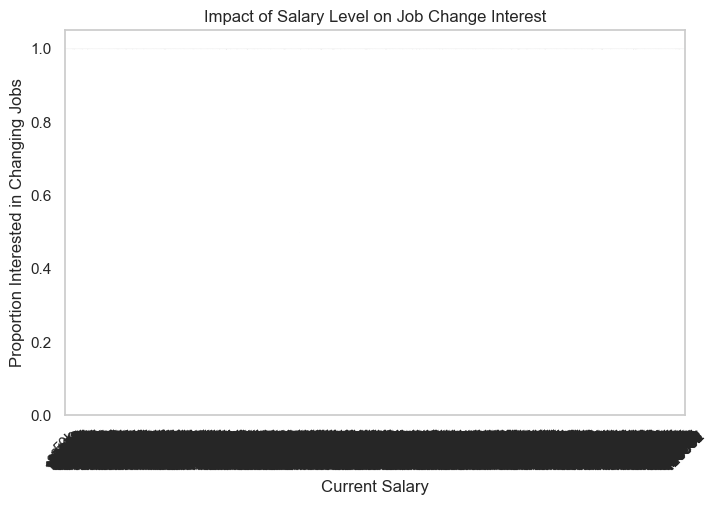

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure target is numeric
df['Interested in Changing Jobs in the Future?'] = df['Interested in Changing Jobs in the Future?'].map({'Yes': 1, 'No': 0})

plt.figure(figsize=(8,5))
sns.barplot(x='Current Salary',
            y='Interested in Changing Jobs in the Future?',
            data=df,
            ci=None)  # Proportion of people interested in changing jobs
plt.ylabel("Proportion Interested in Changing Jobs")
plt.title("Impact of Salary Level on Job Change Interest")
plt.xticks(rotation=45)
plt.show()


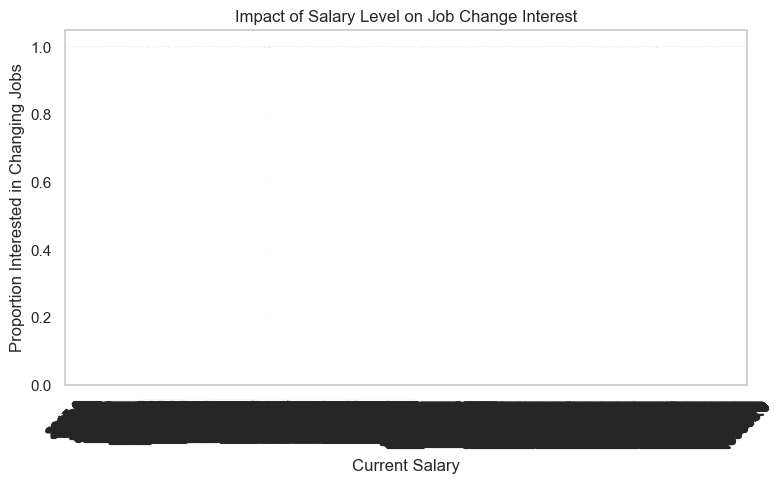

In [39]:
# Convert salary to numeric (if it's not)
df['Current Salary'] = pd.to_numeric(df['Current Salary'], errors='coerce')

# Create average interest by salary level
salary_interest = df.groupby('Current Salary')['Interested in Changing Jobs in the Future?'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='Current Salary', y='Interested in Changing Jobs in the Future?', data=salary_interest, color='skyblue')
plt.ylabel("Proportion Interested in Changing Jobs")
plt.xlabel("Current Salary")
plt.title("Impact of Salary Level on Job Change Interest")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2) Relationship between promotion and salary (Box Plot)

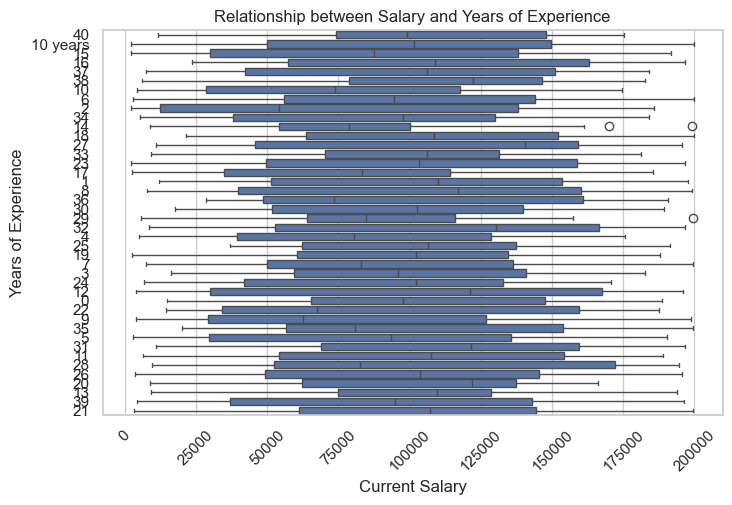

In [41]:
plt.figure(figsize=(8,5))
# Using 'Years of Experience' as a proxy for promotion
sns.boxplot(x='Current Salary', y='Years of Experience', data=df)
plt.title("Relationship between Salary and Years of Experience")
plt.xticks(rotation=45)
plt.show()


### 3) Analyze how working hours affect satisfaction level (Scatter Plot)

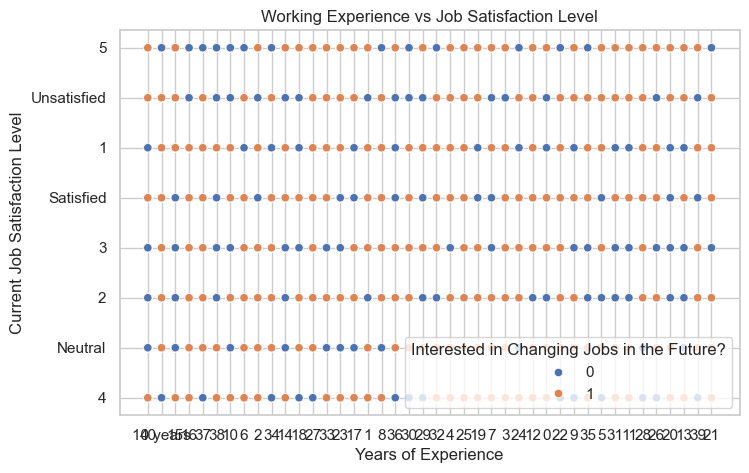

In [43]:
plt.figure(figsize=(8,5))
# Using 'Years of Experience' as x-axis for work exposure
sns.scatterplot(x='Years of Experience',
                y='Current Job Satisfaction Level',
                hue='Interested in Changing Jobs in the Future?',
                data=df)
plt.title("Working Experience vs Job Satisfaction Level")
plt.show()


### 4) Compare attrition rate across different departments (Pie Chart)

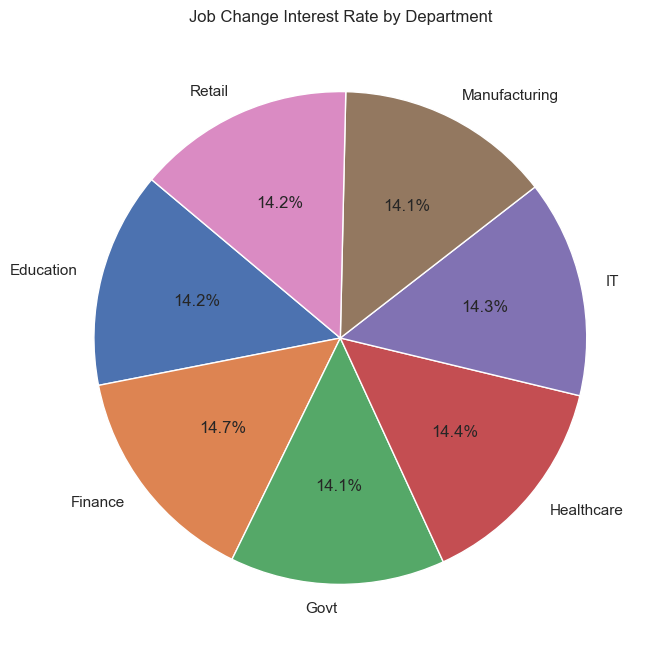

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Normalize the column
df["Interested in Changing Jobs in the Future?"] = (
    df["Interested in Changing Jobs in the Future?"]
    .astype(str)       # force everything to string
    .str.strip()       # remove extra spaces
    .str.lower()       # normalize to lowercase
)

# Step 2: Map Yes/No to 1/0
df["Interested in Changing Jobs in the Future?"] = df["Interested in Changing Jobs in the Future?"].replace({'yes':1, 'no':0, 'nan': pd.NA})

# Step 3: Convert to numeric, coercing errors, and drop NA
df["Interested in Changing Jobs in the Future?"] = pd.to_numeric(df["Interested in Changing Jobs in the Future?"], errors='coerce')
df_clean = df.dropna(subset=["Interested in Changing Jobs in the Future?"])


# Step 4: Group by department
dept_attrition = df_clean.groupby("Current Industry/Domain")["Interested in Changing Jobs in the Future?"].mean()

# Step 5: Plot pie chart
plt.figure(figsize=(8,8))
plt.pie(
    dept_attrition,
    labels=dept_attrition.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Job Change Interest Rate by Department")
plt.show()